# Faster R-CNN experiments
This file contains experiments for my Faster R-CNN implementation. To access GPUs/TPUs, I ran this file in Google Colaboratory.

## Setup
To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git add .
!git stash
!git pull
```
----

In [ ]:
#Mounting our Google Drive...
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 2.2MB 26.3MB/s 
     |████████████████████████████████| 17.4MB 169kB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 15.3MB 126kB/s 
     |████████████████████████████████| 11.6MB 43.2MB/s 
     |████████████████████████████████| 808kB 42.4MB/s 
     |████████████████████████████████| 8.3MB 32.0MB/s 
     |████████████████████████████████| 38.2MB 73kB/s 
     |████████████████████████████████| 276kB 54.0MB/s 
     |████████████████████████████████| 829kB 47.9MB/s 
     |████████████████████████████████| 122kB 50.1MB/s 
     |████████████████████████████████| 10.6MB 42.0MB/s 
     |████████████████████████████████| 317kB 59.3MB/s 
     |████████████████████████████████| 59.9MB 47kB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 1.3MB 38.1MB/s 
     |████████████████████████████████| 296kB 51.8MB/s 
     |████████████████████████████████| 143kB 52.

In [ ]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEED = config['random_seed']
HYPERPARAMETERS = config['faster_rcnn_params']

In [ ]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'object_detection'))

from faster_rcnn_model import *
from bird_dataset import *

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

## Model training
If the Colab runtime disconnects, you'll have to load from a post-epoch `PyTorch Lightning` model save.

In [ ]:
#Setting our random seed for all operations (PyTorch, numpy, python.random)
#  especially important if Colab exits the runtime... ensures that we get the same train/val/test split!
seed_everything(SEED);

Global seed set to 1693


In [ ]:
#Creating a dataset and subsetting into train/validation/test splits - run the "seed_everything" directly before this cell!
bird_dataset_train = BirdDataset(root_dir = DATA_FP, 
                                 transforms = get_transforms(train = True), 
                                 tiling_method = 'random', #random tiling for training
                                 num_tiles = 5, 
                                 max_neg_examples = 1)
bird_dataset_eval = BirdDataset(root_dir = DATA_FP, 
                                transforms = get_transforms(train = False), 
                                tiling_method = 'w_o_overlap') #tiling w/o overlap for validation/testing

#  here, we limit which PARENT images each set gets to see!
indices = torch.randperm(len(bird_dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(bird_dataset_train, indices[ : 24]) #24 images in train
dataset_val = torch.utils.data.Subset(bird_dataset_eval, indices[24 : 28]) #4 images in val
dataset_test = torch.utils.data.Subset(bird_dataset_eval, indices[28 : ]) #6 images in test

In [ ]:
#Wrapping our train/validation/test sets in DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size = HYPERPARAMETERS['batch_size'], shuffle = True, collate_fn = collate_w_tiles) 
dataloader_val = DataLoader(dataset_val, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_w_tiles) 
dataloader_test = DataLoader(dataset_test, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_w_tiles) 

In [ ]:
#Instantiating the pre-trained model and wrapping it in PyTorch Lightning class
model = get_faster_rcnn(num_classes = 2) #class 0 is reserved for background (may not be necessary) + class 1 is bird class
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION']) #IoU threshold will be used for validation AP!
pl_model; #checking out the model summary - delete ";" if you want to see it!

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
#Setting up logger 
logging_directory = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'evaluation')
logger = CSVLogger(logging_directory, name = 'initial_training_6.10.2021') #REMEMBER: change this when you shift experiments!

In [ ]:
#Training the model w/early stopping on "Val_AP" (remember: we only have one class so this is equivalent to mAP)
checkpoint_dir = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'trainer_checkpoints')

early_stopping_callback = EarlyStopping(monitor = 'Val_AP', patience = 10, mode = 'max') #makes it so that we don't have to babysit the model as much
lr_callback = LearningRateMonitor(logging_interval = 'step')

trainer = Trainer(gpus = 1, max_epochs = 150, callbacks = [early_stopping_callback, lr_callback], default_root_dir = checkpoint_dir, logger = logger) 
trainer.fit(pl_model, train_dataloader = dataloader_train, val_dataloaders = dataloader_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Global seed set to 1693


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [ ]:
#Saving the model
save_name = 'faster_rcnn_val_w_o_overlap_6.9.2021.pth'
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name))

## Qualitatively inspecting predictions from the trained model
To avoid memory errors, we have to save and load the model. Make sure to restart the runtime!

In [ ]:
#Loading the model
save_name = 'faster_rcnn_random_tiling_6.8.2021.pth'
model = get_faster_rcnn(num_classes = 2)
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate']) 

In [ ]:
#Predicting on one parent image - this is currently happening on CPU... prediction w/PyTorch Lightning's trainer seems not to work correctly!
images, targets, _, _ = next(iter(dataloader_test))
images, targets = images[ : 10], targets[ : 10] 
preds = pl_model(images)

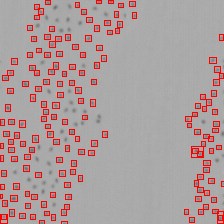

In [ ]:
#Plotting an image and predicted bboxes
#  TODO: might need NMS on the prediction outputs (maybe change "box_nms_thresh" argument in "get_faster_rcnn")
#  TODO: maybe make a wrapper function to visualize predictions...
index = 3
img = np.moveaxis(images[index].numpy(), 0, -1) * 255
bboxes = preds[index]['boxes'].tolist()

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bboxes:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

In [ ]:
#Checking counts
print(f'We predicted {len(bboxes)} birds and there are actually {len(targets[index]["boxes"])} birds in this image')

We predicted 92 birds and there are actually 102 birds in this image


## Model testing

In [ ]:
#Loading the model
save_name = 'faster_rcnn_val_w_o_overlap_6.9.2021.pth'
model = get_faster_rcnn(num_classes = 2) 
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'], iou_threshold = HYPERPARAMETERS['iou_threshold_EVALUATION'])

In [ ]:
#Using the saved model and the test set to evaluate (via AP)
trainer = Trainer(gpus = 1)
results = trainer.test(pl_model, test_dataloaders = dataloader_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test_AP': 0.6173589535106475,
 'Test_FP': 1584.0,
 'Test_MAE': 424.8333333333333,
 'Test_RMSE': 833.7078824944223,
 'Test_TP': 5360.0}
--------------------------------------------------------------------------------
